In [10]:
import matplotlib.pyplot as plt
import numpy as np
from utils import reshape_data, get_dataset_seismic, get_dataloader, SeismicDataset, get_weights
import torch
from torchvision import transforms
from models.networks import DemoNet, UNetRes
from torchsummary import summary

In [11]:
net = DemoNet().to('cuda')  
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 28, 28]           1,000
            Conv2d-2          [-1, 100, 14, 14]          90,100
            Conv2d-3              [-1, 1, 7, 7]             901
            Linear-4                   [-1, 10]             500
Total params: 92,501
Trainable params: 92,501
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.75
Params size (MB): 0.35
Estimated Total Size (MB): 1.10
----------------------------------------------------------------


In [12]:
n_channels = 3
net2 = UNetRes(in_nc=n_channels+1, out_nc=n_channels, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose").to('cuda')
summary(net2, (4, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           2,304
            Conv2d-2         [-1, 64, 256, 256]          36,864
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
          ResBlock-5         [-1, 64, 256, 256]               0
            Conv2d-6         [-1, 64, 256, 256]          36,864
              ReLU-7         [-1, 64, 256, 256]               0
            Conv2d-8         [-1, 64, 256, 256]          36,864
          ResBlock-9         [-1, 64, 256, 256]               0
           Conv2d-10         [-1, 64, 256, 256]          36,864
             ReLU-11         [-1, 64, 256, 256]               0
           Conv2d-12         [-1, 64, 256, 256]          36,864
         ResBlock-13         [-1, 64, 256, 256]               0
           Conv2d-14         [-1, 64, 2

In [13]:
get_weights()

Weights already downloaded!


In [14]:
weights_path = 'weights/drunet_color.pth'
net2.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [15]:
weights_lora = [(n, type(m)) for n, m in net2.named_modules()]
weights_lora = [(n, m) for n, m in weights_lora if m == torch.nn.modules.conv.Conv2d]
weights_lora = [n for n, m in weights_lora]
#weights_lora[1][1] == torch.nn.modules.conv.Conv2d

In [16]:
weights_lora

['m_head',
 'm_down1.0.res.0',
 'm_down1.0.res.2',
 'm_down1.1.res.0',
 'm_down1.1.res.2',
 'm_down1.2.res.0',
 'm_down1.2.res.2',
 'm_down1.3.res.0',
 'm_down1.3.res.2',
 'm_down1.4',
 'm_down2.0.res.0',
 'm_down2.0.res.2',
 'm_down2.1.res.0',
 'm_down2.1.res.2',
 'm_down2.2.res.0',
 'm_down2.2.res.2',
 'm_down2.3.res.0',
 'm_down2.3.res.2',
 'm_down2.4',
 'm_down3.0.res.0',
 'm_down3.0.res.2',
 'm_down3.1.res.0',
 'm_down3.1.res.2',
 'm_down3.2.res.0',
 'm_down3.2.res.2',
 'm_down3.3.res.0',
 'm_down3.3.res.2',
 'm_down3.4',
 'm_body.0.res.0',
 'm_body.0.res.2',
 'm_body.1.res.0',
 'm_body.1.res.2',
 'm_body.2.res.0',
 'm_body.2.res.2',
 'm_body.3.res.0',
 'm_body.3.res.2',
 'm_up3.1.res.0',
 'm_up3.1.res.2',
 'm_up3.2.res.0',
 'm_up3.2.res.2',
 'm_up3.3.res.0',
 'm_up3.3.res.2',
 'm_up3.4.res.0',
 'm_up3.4.res.2',
 'm_up2.1.res.0',
 'm_up2.1.res.2',
 'm_up2.2.res.0',
 'm_up2.2.res.2',
 'm_up2.3.res.0',
 'm_up2.3.res.2',
 'm_up2.4.res.0',
 'm_up2.4.res.2',
 'm_up1.1.res.0',
 'm_up1.1

In [17]:
get_dataset_seismic()

Dataset already downloaded!


In [18]:
data_path = 'data/dataset.npy'
number_degradations = 6 # total 12
reshape_data(data_path, number_degradations)

Data already reshaped!


In [19]:
dataset = np.load(f'data/dataset_reshaped.npy', allow_pickle=True)
print(dataset.shape); print(len(dataset))

(12000, 2, 256, 256)
12000


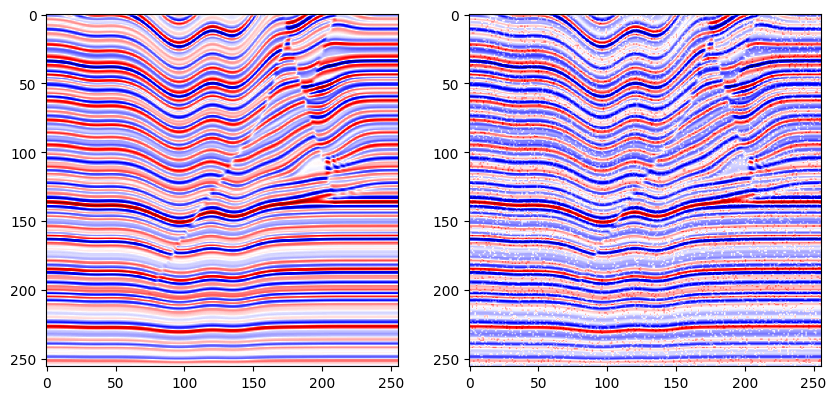

In [20]:
idx = 12
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(dataset[idx][0], cmap='seismic')
ax[1].imshow(dataset[idx][1], cmap='seismic')
plt.show()


In [21]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((128, 128)),])
dataset = SeismicDataset(data_path='data/dataset_reshaped.npy', transform=transform)

12000


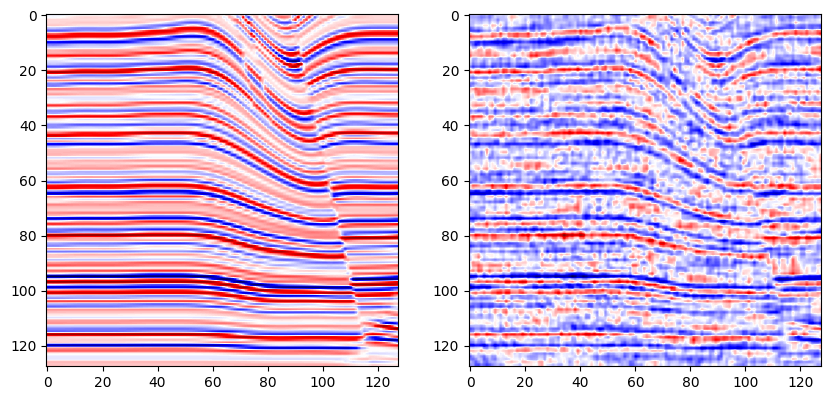

In [22]:
print(dataset.__len__())
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(dataset[11][0].squeeze(), cmap='seismic')
ax[1].imshow(dataset[11][1].squeeze(), cmap='seismic')
plt.show()

In [23]:
trainloader, valoader, testloader = get_dataloader(batch_size=32, num_workers=0, data_path='data/dataset_reshaped.npy', im_size=(256,256))

In [24]:
len(trainloader), len(valoader), len(testloader)

(300, 38, 38)

In [27]:
img, degr = next(iter(trainloader))
print(img.shape, degr.shape)

torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])


In [28]:
# concatenation 4 times image input, 3 times degrataion

img = torch.cat((img, img, img, img), dim=1)
degr = torch.cat((degr, degr, degr), dim=1)

print(img.shape, degr.shape)

torch.Size([32, 4, 256, 256]) torch.Size([32, 3, 256, 256])


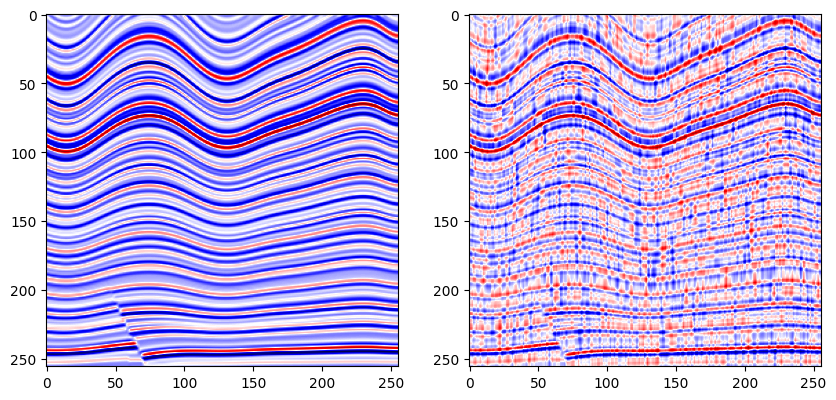

In [26]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img[-1].squeeze(), cmap='seismic')
ax[1].imshow(degr[-1].squeeze(), cmap='seismic')
plt.show()